In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
def generate_sample(alpha, beta, n_samples, sigma_2=1):
    m = lambda x: np.sin(1 / (x / 3 + 0.1))

    X = np.random.beta(a=alpha, b=beta, size=n_samples)
    epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma_2), size=n_samples)
    Y = m(X) + epsilon

    response = Y
    covariate = X
    return covariate, response


def estimate_parameters(covariate, response, bandwith, p=1):
    X = covariate
    Y = response
    h = bandwith

    quartic_kernel = lambda x: (np.abs(x) <= 1) * (15 / 16) * (1 - x**2)**2

    #W = np.diag(quartic_kernel((X - x) / h))
    #X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])
    #beta_x = np.inv(X.T @ W @ X) @ X.T @ W @ Y

    def beta_est(x_array):
        beta_x = []
        for (idx, x) in enumerate(x_array):
            W = np.diag(quartic_kernel((X - x) / h))
            X_matrix = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])
            beta_x.append(np.linalg.inv(X_matrix.T @ W @ X_matrix) @ X_matrix.T @ W @ Y)
        return np.array(beta_x) # beta_x
    
    return beta_est

x, y = generate_sample(0.1, 0.1, 10000, 0.1)

beta_fct = estimate_parameters(x, y, 0.1, p=2)
p = np.linspace(0, 1, 100)
beta_values = beta_fct(p) 

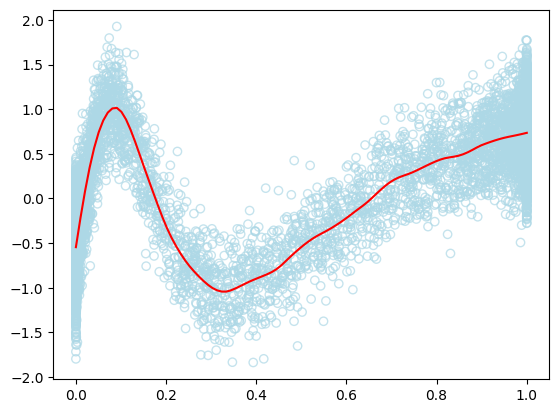

In [86]:
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='lightblue', alpha=0.7)
plt.plot(p, beta_values[:, 0], color="red", label=r"fit ($\hat\beta_0)$")
#plt.plot(p, beta_values[:, 1], color="orange", label = r"derivative ($\hat\beta_1)$")
#plt.plot(p, 2*beta_values[:, 2], color="yellow", label = r"second ($\hat\beta_2)$")

In [ ]:

def estimate_h_theta(covariate, response, bandwith = 0.1, N_blocks = 10):

    # Build the blocks
    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)  
    X_sorted = covariate[sorted_indices]     
    Y_sorted = response[sorted_indices] 
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate for each block:
    for i in range(len(covariate_blocks)):
        beta_est = estimate_parameters(covariate_blocks[i], response_blocks[i], bandwith, p = 5)
        m = 0
    


    # Compute h_{IMSE}
    h_IMSE = 0



    # Compute theta_{22}
    theta_22 = 0


    return h_IMSE, theta_22
